# Compare Co-Expression Modules

**Created**: 27 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("Rcpp")) {
    install.packages("Rcpp")
}

Loading required namespace: patchwork

Loading required namespace: Rcpp



In [2]:
library(tidyverse)
library(patchwork)
library(Rcpp)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

modules.cap <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.cap.csv")
eigengenes.cap <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.cap.csv", row.names=1)
variance.explained.cap <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.cap.csv")

modules.fp <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.fp.csv")
eigengenes.fp <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.fp.csv", row.names=1)
variance.explained.fp <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.fp.csv")

## Jaccard Index

The Jaccard Index $J$ is a measure of similarity between two sets $A$ and $B$. It is defined as 

$$J = \frac{|A\cap B|}{|A\cup B|}$$

and is limited to the interval $J\in [0,1]$.

To assign significance to the overlap between two sets, we use the hypergeometric distribution test. The one-sided alternative of this test is equivalent to Fisher's exact test.

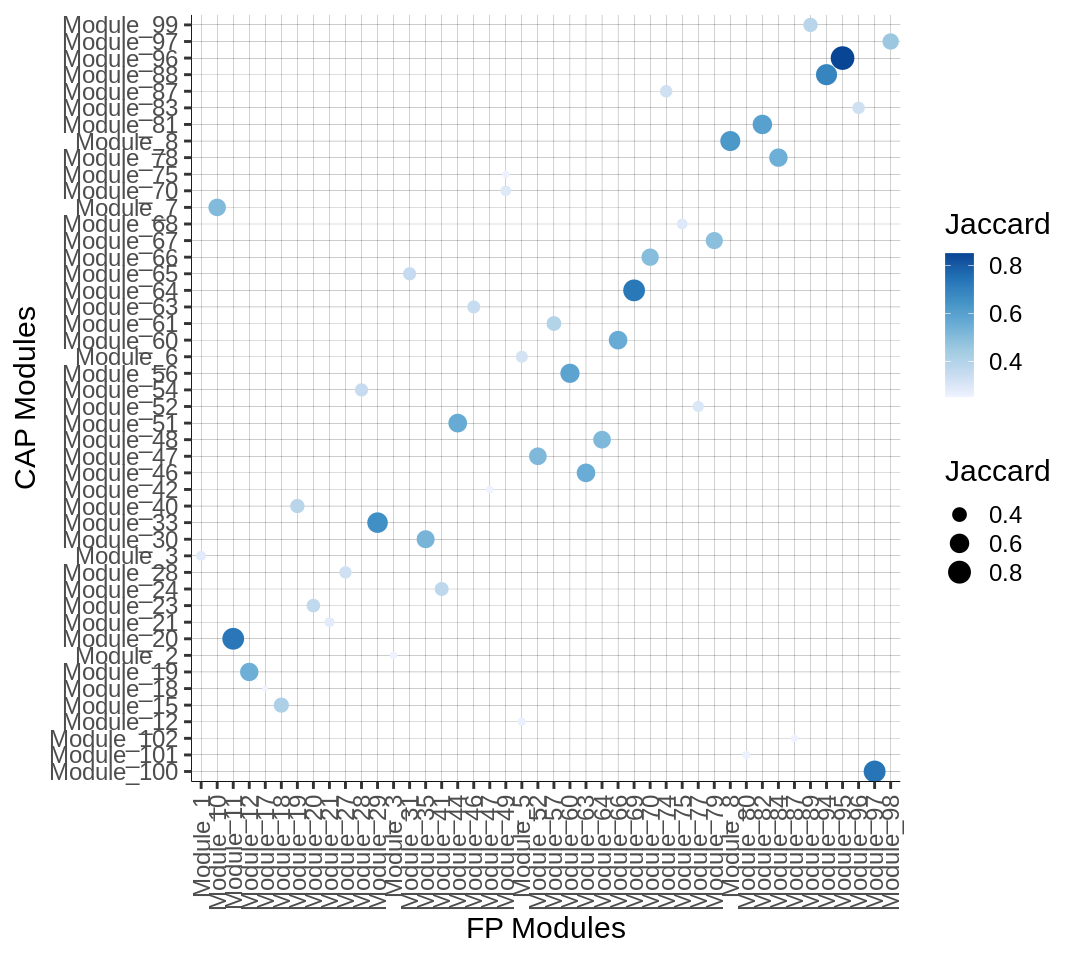

In [5]:
# Define Jaccard function to calculate Jaccard index between two sets
jaccard <- function(x, y) {
  return(length(intersect(x, y)) / length(union(x, y)))
}

# Define the function that will compute Fisher's exact test for overlap
gene.background.n <- length(union(modules.cap$Gene, modules.fp$Gene))
overlap.test <- function(x, y) {
  
  overlap = length(intersect(x, y))
  in.x.not.y = length(setdiff(x, y))
  in.y.not.x = length(setdiff(y, x))
  in.none = gene.background.n - overlap - in.x.not.y - in.y.not.x
  
  contingency.table = matrix(
    c(overlap, in.y.not.x, in.x.not.y, in.none),
    nrow=2
  )
  
  return(fisher.test(contingency.table, alternative="greater")$p.value)
}

modules.cap.names <- paste0("Module_", 1:ncol(eigengenes.cap))
modules.fp.names <- paste0("Module_", 1:ncol(eigengenes.fp))

modules.cap.list <- split(modules.cap, modules.cap$Module)
modules.fp.list <- split(modules.fp, modules.fp$Module)

mods.jaccard <- lapply(modules.cap.names, function(cap.mod.name) {
  lapply(modules.fp.names, function(fp.mod.name) {
    
    genes.cap = modules.cap.list[[cap.mod.name]]$Gene
    genes.fp = modules.fp.list[[fp.mod.name]]$Gene
    
    jaccard.idx = jaccard(genes.cap, genes.fp)
    
    jaccard.p.val = overlap.test(genes.cap, genes.fp)
    
    return(list(Module.CAP=cap.mod.name, Module.FP=fp.mod.name, Jaccard=jaccard.idx, P.Value=jaccard.p.val))
  })
})

mods.jaccard <- do.call(rbind, lapply(mods.jaccard, function(x) { do.call(rbind, x) })) %>%
  as.data.frame() %>%
  dplyr::mutate(across(everything(), unlist)) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH"))

options(repr.plot.width=9, repr.plot.height=8)

mods.jaccard %>%
  dplyr::filter(Adjusted.P.Value < 0.05, Jaccard > 0.25) %>%
  dplyr::mutate(Module.CAP=factor(Module.CAP, levels=sort(unique(Module.CAP)))) %>%
  dplyr::mutate(Module.FP=factor(Module.FP, levels=sort(unique(Module.FP)))) %>%
  ggplot() +
  geom_point(aes(x=Module.FP, y=Module.CAP, color=Jaccard, size=Jaccard)) +
  scale_color_distiller(palette="Blues", direction=1) +
  xlab("FP Modules") + ylab("CAP Modules") +
  ggplot_theme +
  theme(legend.position="right", axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), panel.grid.major=element_line(size=0.05))
ggsave("04_Expression/results/cap_fp_module_overlap.svg", width=9, height=8)

## Variation of Information

[Variation of Information](https://en.wikipedia.org/wiki/Variation_of_information) is a measure of distance between two clusterings from informatiom theory. Here, I generate null distributions for the Variation of Information (VI) between All Samples vs. CAP, All Samples vs. FP, and CAP vs. FP. We can compare the realied VI values from WGCNA to the null distributions to determine the significance of the overlap of genes between modules from these different clusterings.

If the VI is significantly small between two partitions, we can conclude that the partitions have generated similar modules.

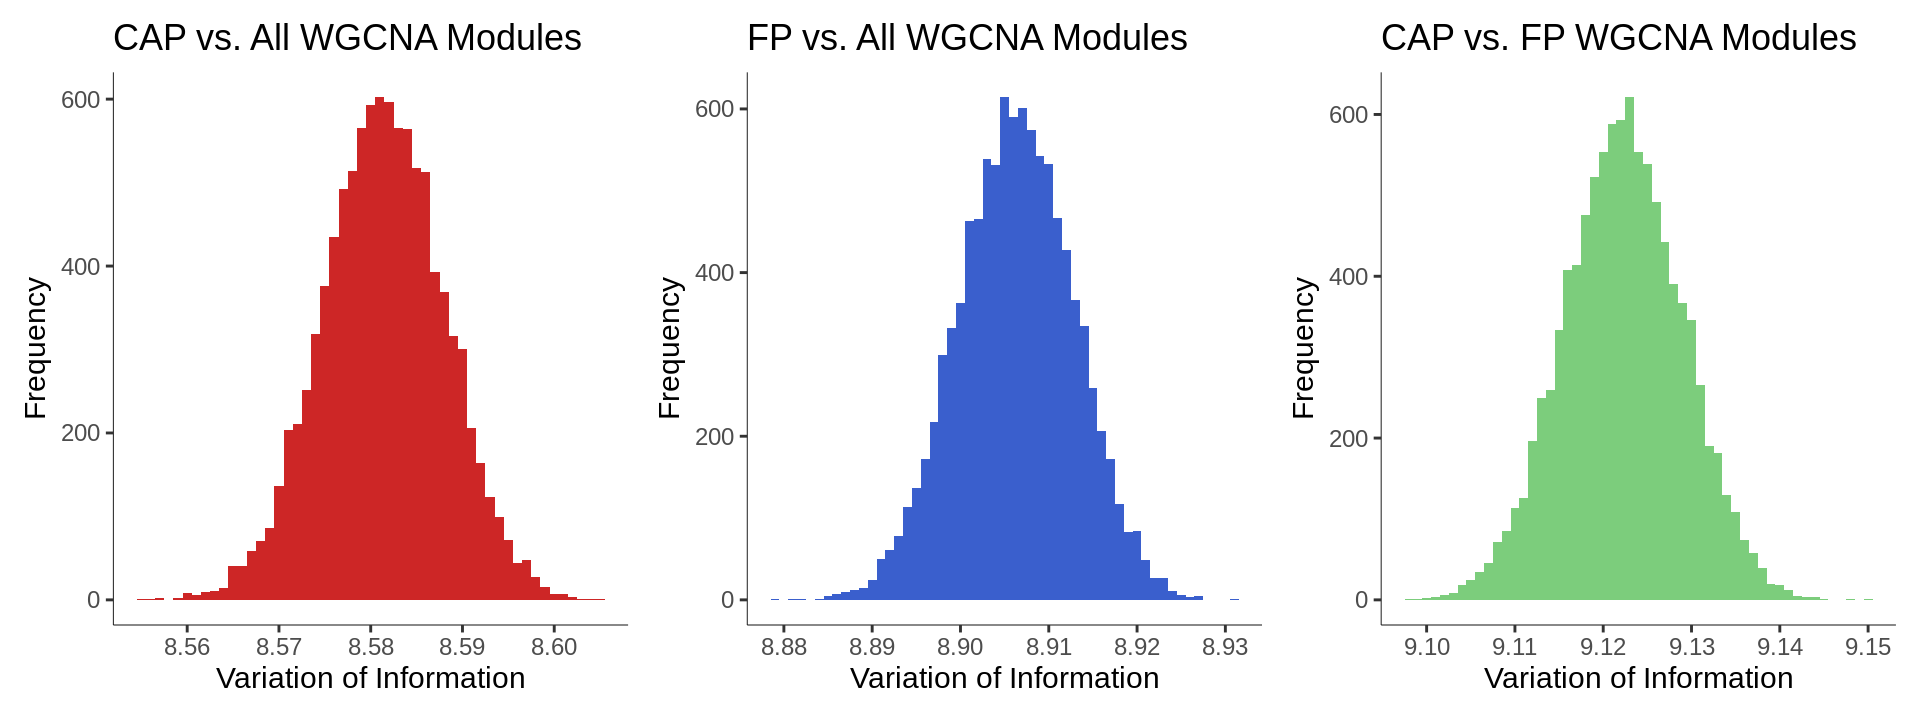

In [6]:
# Fast implementation of Variation of Information calculation
Rcpp::sourceCpp("04_Expression/scripts/utils/varition_of_information.cpp")

clusters <- as.numeric(as.factor(modules$Module)) - 1
cap.clusters <- as.numeric(as.factor(modules.cap$Module)) - 1
fp.clusters <- as.numeric(as.factor(modules.fp$Module)) - 1
clusters.n <- length(unique(clusters))
cap.clusters.n <- length(unique(cap.clusters))
fp.clusters.n <- length(unique(fp.clusters))

vi.cap.all <- vi(cap.clusters, cap.clusters.n, clusters, clusters.n)
vi.fp.all <- vi(fp.clusters, fp.clusters.n, clusters, clusters.n)
vi.cap.fp <- vi(cap.clusters, cap.clusters.n, fp.clusters, fp.clusters.n)

# Null Distribution CAP vs. All
vi.clustering.perms <- list()
N.PERMS = 10000
for (i in 1:N.PERMS) {
  x = sample(cap.clusters)
  y = sample(clusters)
  vi.clustering.perms[[i]] <- vi(x, cap.clusters.n, y, clusters.n)
}

p1 <- as.matrix(unlist(vi.clustering.perms)) %>%
  as.data.frame() %>%
  dplyr::select(VI=1) %>%
  ggplot() +
  geom_histogram(aes(x=VI), binwidth=0.001, fill="firebrick3") +
  xlab("Variation of Information") + ylab("Frequency") +
  ggtitle("CAP vs. All WGCNA Modules") +
  ggplot_theme

# Null Distribution FP vs. All
vi.clustering.perms <- list()
N.PERMS = 10000
for (i in 1:N.PERMS) {
  x = sample(fp.clusters)
  y = sample(clusters)
  vi.clustering.perms[[i]] <- vi(x, fp.clusters.n, y, clusters.n)
}

p2 <- as.matrix(unlist(vi.clustering.perms)) %>%
  as.data.frame() %>%
  dplyr::select(VI=1) %>%
  ggplot() +
  geom_histogram(aes(x=VI), binwidth=0.001, fill="royalblue3") +
  xlab("Variation of Information") + ylab("Frequency") +
  ggtitle("FP vs. All WGCNA Modules") +
  ggplot_theme

# Null Distribution CAP vs. FP
vi.clustering.perms <- list()
N.PERMS = 10000
for (i in 1:N.PERMS) {
  x = sample(cap.clusters)
  y = sample(fp.clusters)
  vi.clustering.perms[[i]] <- vi(x, cap.clusters.n, y, fp.clusters.n)
}

p3 <- as.matrix(unlist(vi.clustering.perms)) %>%
  as.data.frame() %>%
  dplyr::select(VI=1) %>%
  ggplot() +
  geom_histogram(aes(x=VI), binwidth=0.001, fill="palegreen3") +
  xlab("Variation of Information") + ylab("Frequency") +
  ggtitle("CAP vs. FP WGCNA Modules") +
  ggplot_theme

# Plot Null Distributions
options(repr.plot.width=16, repr.plot.height=6)
p1 + p2 + p3
ggsave("04_Expression/results/modules_variation_of_information.svg", width=16, height=6)

In [7]:
cat("VI between CAP and All Samples:", vi.cap.all, "\n")
cat("VI between FP and All Samples:", vi.fp.all, "\n")
cat("VI between CAP and FP:", vi.cap.fp, "\n")

VI between CAP and All Samples: 1.366976 
VI between FP and All Samples: 1.970374 
VI between CAP and FP: 1.699754 
